In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymodulon.compare import *
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.enrichment import *
from pymodulon.util import explained_variance  

In [2]:
tpm = pd.read_csv('../data/ICA_data_fixed_sample_table/log_tpm_norm.csv',index_col='gene_id')
#gene_table = pd.read_csv('../data/Annotations/yarrowia_NCBI_table.csv',index_col='Locus tag')
sample_table = pd.read_csv('../data/ICA_data_fixed_sample_table/final_metadata.csv',index_col='Unnamed: 0')
A = pd.read_csv('../data/ICA_data_fixed_sample_table/A.csv',index_col='Unnamed: 0')
new_M = pd.read_csv('../data/ICA_data_fixed_sample_table/M.csv',index_col='gene_id')
new_M.index = [w.replace('gene-','') for w in new_M.index]
old_M = pd.read_csv('../data/ICA_data/M.csv',index_col='gene_id')
old_M.index = [w.replace('gene-','') for w in old_M.index]
tpm.index = [w.replace('gene-','') for w in tpm.index]
TRN = pd.read_csv('../data/Annotations/yarrowiaTRN.csv',index_col = 'Unnamed: 0')

In [3]:
sample_table

,File name,condition,project,reference_condition,Strain,Mode of operation,Media,Limitation,C-source,Growth rate,DO,pH,Temperature,Read1,Read2
yl_001,PD019 A1 S02 #1,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S021A_1.fq.gz,ylipolytic2025_repeat/PD019A1S021A_2.fq.gz
yl_002,PD019 A1 S02 #2,µ0.05_DO50,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,50,6,30,ylipolytic2025_repeat/PD019A1S022A_1.fq.gz,ylipolytic2025_repeat/PD019A1S022A_2.fq.gz
yl_003,PD019 A1 S03 #2,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S032A_1.fq.gz,ylipolytic2025_repeat/PD019A1S032A_2.fq.gz
yl_004,PD019 A1 S03 #1,µ0.05_DO25,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,25,6,30,ylipolytic2025_repeat/PD019A1S031A_1.fq.gz,ylipolytic2025_repeat/PD019A1S031A_2.fq.gz
yl_005,PD019 A1 S04 #1,µ0.05_DO10,O2_oscillation_0.05,µ0.05_DO10,W29,Continuous,Delft,Carbon,Glucose,0.05,10,6,30,ylipolytic2025_repeat/PD019A1S041A_1.fq.gz,ylipolytic2025_repeat/PD019A1S041A_2.fq.gz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yl_151,NaN,Single_oscillation_#4.2_DO40,O2_oscillation,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...
yl_152,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,40,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...
yl_153,NaN,Repeated_oscillation_#5.2_DO40,O2_oscillation,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...
yl_154,NaN,Repeated_oscillation_#6.2_DO0,O2_oscillation,Single_oscillation_#1.2_DO40,W29,Continuous,Delft,Oxygen,Glucose,NaN,0,6,30,s3://modulome/jayanth/yarrowia_lipolytica_sequ...,s3://modulome/jayanth/yarrowia_lipolytica_sequ...


In [4]:
links,dots = compare_ica(old_M,new_M)

In [5]:
maps = {}

for map in links:
    imod = map[0]
    all_imod_maps = [w for w in links if w[0]==imod]
    best_imod_map = [w[2] for w in all_imod_maps]
    maps[imod] = all_imod_maps[best_imod_map.index(max(best_imod_map))][1]





In [6]:
ica_data = load_json_model('../data/yarrowia2025.json')

In [7]:
trn = pd.read_csv('../data/Annotations/yarrowiaTRN.csv',index_col='Unnamed: 0')
df = pd.read_csv('cl_w29_protein_maps.tsv',sep='\t',index_col=0)

gene_map = []
for gene in trn['gene_id'].tolist():
    if(df[df['gene_a']==gene].shape[0]>0):
        gene_map.append(df[df['gene_a']==gene]['gene_b'].tolist()[0])
    else:
        gene_map.append('NA')   

trn['W29_gene_map'] = gene_map
trn = trn[['regulator','W29_gene_map']].rename(columns={'W29_gene_map':'gene_id'})



  0%|          | 0/39 [00:00<?, ?it/s]

600

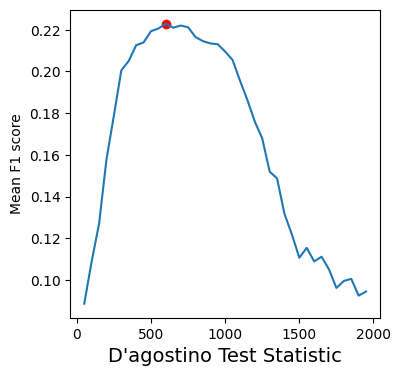

In [8]:
new_ica_data = IcaData(new_M,A,X=tpm,gene_table=ica_data.gene_table,sample_table=sample_table,trn=trn,threshold_method='dagostino')
new_ica_data.reoptimize_thresholds()



In [9]:
# create new imodulon table

imod_descriptions = pd.read_csv('../data/ICA_data_fixed_sample_table/imod_desc.csv')

sizes = []
evs = []

for imod in imod_descriptions['iModulon '].tolist():
    sizes.append(new_ica_data.view_imodulon(imod).shape[0])
    evs.append(explained_variance(new_ica_data,imodulons=imod))

imod_descriptions['ngenes'] = sizes 
imod_descriptions['explained_variance'] = evs

imod_descriptions 

,iModulon,iModulon Name,Descriptors,COGs,Category,ngenes,explained_variance
0,23,DAL81,Ammonia degradation/Nitrogen related,E (Amino acid transport),Metabolism,114,0.020548
1,14,UC1,Contains some sugar related proteins?,S (Unknown),Uncharacterized,75,0.009010
2,0,FDH,Formate Dehydrogenase,C (Energy Production and Conversion),Energy,58,0.011639
3,36,UC19,N.A,N.A,N.A,0,0.031540
4,30,ADR1,CRP like - non glucose carbon metabolism,Q (Catabolism),Metabolism,178,0.071492
5,18,UC2,N.A,S (Unknown),Uncharacterized,104,0.039261
6,19,SWI5,D (Cell cycle control),D (Cell cycle control),Cell division,66,0.019581
7,26,UC3,N.A,G(Carbohydrate transport and metabolism),Uncharacterized,265,0.030003
8,6,UC4,N.A,S (Unknown),Uncharacterized,253,0.014527
9,5,UC5,N.A,"O (Post translation mods, chaperons)",Uncharacterized,92,0.003345


In [10]:
imod_descriptions = imod_descriptions.set_index('iModulon ')
imod_descriptions.index.name = None
imod_descriptions

,iModulon Name,Descriptors,COGs,Category,ngenes,explained_variance
23,DAL81,Ammonia degradation/Nitrogen related,E (Amino acid transport),Metabolism,114,0.020548
14,UC1,Contains some sugar related proteins?,S (Unknown),Uncharacterized,75,0.009010
0,FDH,Formate Dehydrogenase,C (Energy Production and Conversion),Energy,58,0.011639
36,UC19,N.A,N.A,N.A,0,0.031540
30,ADR1,CRP like - non glucose carbon metabolism,Q (Catabolism),Metabolism,178,0.071492
18,UC2,N.A,S (Unknown),Uncharacterized,104,0.039261
19,SWI5,D (Cell cycle control),D (Cell cycle control),Cell division,66,0.019581
26,UC3,N.A,G(Carbohydrate transport and metabolism),Uncharacterized,265,0.030003
6,UC4,N.A,S (Unknown),Uncharacterized,253,0.014527
5,UC5,N.A,"O (Post translation mods, chaperons)",Uncharacterized,92,0.003345


In [11]:
repeated = imod_descriptions.index[imod_descriptions.index.duplicated()].unique()
print(repeated)

Index([], dtype='int64')


In [12]:
new_ica_data.imodulon_table = imod_descriptions


In [13]:
save_to_json(new_ica_data,'../data/yarrowia2025_fixed.json')